In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import math

from tqdm import tqdm_notebook as tqdm 

from Dataset.Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights,DualEncodingDecoding_U_Net,AttnUNet,\
DualEncoding_U_Net_without_asm,U_Net
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,HV_Loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
pretrained=False
predict_hover=False

In [3]:
# def get_gradient_hv(l, h_ch, v_ch):
#     """
#     Calculate the horizontal partial differentiation for horizontal channel
#     and the vertical partial differentiation for vertical channel.
#     The partial differentiation is approximated by calculating the central differnce
#     which is obtained by using Sobel kernel of size 5x5. The boundary is zero-padded
#     when channel is convolved with the Sobel kernel.
#     Args:
#         l (tensor): tensor of shape NHWC with C should be 2 (1 channel for horizonal 
#                     and 1 channel for vertical)
#         h_ch(int) : index within C axis of `l` that corresponds to horizontal channel
#         v_ch(int) : index within C axis of `l` that corresponds to vertical channel
#     """
#     def get_sobel_kernel(size):
#         assert size % 2 == 1, 'Must be odd, get size={}'.format(size)

#         h_range = np.arange(-size//2+1, size//2+1, dtype=np.float32)
#         v_range = np.arange(-size//2+1, size//2+1, dtype=np.float32)
#         h, v = np.meshgrid(h_range, v_range)
#         kernel_h = h / (h * h + v * v + 1.0e-15)
#         kernel_v = v / (h * h + v * v + 1.0e-15)
#         return kernel_h, kernel_v            

#     mh, mv = get_sobel_kernel(5)
#     mh = tf.constant(mh, dtype=tf.float32)
#     mv = tf.constant(mv, dtype=tf.float32)

#     mh = tf.reshape(mh, [5, 5, 1, 1])
#     mv = tf.reshape(mv, [5, 5, 1, 1])

#     # central difference to get gradient, ignore the boundary problem  
#     h = tf.expand_dims(l[...,h_ch], axis=-1)  
#     v = tf.expand_dims(l[...,v_ch], axis=-1)  
#     dh = tf.nn.conv2d(h, mh, strides=[1, 1, 1, 1], padding='SAME')
#     dv = tf.nn.conv2d(v, mv, strides=[1, 1, 1, 1], padding='SAME')
#     output = tf.concat([dh, dv], axis=-1)
#     return output

In [4]:

h_e_train_patch_dir='Data/CPM_17/{}/H_E_patches'.format('Train')
h_train_patch_dir='Data/CPM_17/{}/H_patches'.format('Train')

nuclei_mask_train_patch_dir='Data/CPM_17/{}/nuclei_patches'.format('Train')
boundary_mask_train_patch_dir='Data/CPM_17/{}/boundary_patches'.format('Train')
hor_train_patch_dir='Data/CPM_17/{}/horizontal_patches'.format('Train')
ver_train_patch_dir='Data/CPM_17/{}/vertical_patches'.format('Train')

h_e_test_patch_dir='Data/CPM_17/{}/H_E_patches'.format('Test')
h_test_patch_dir='Data/CPM_17/{}/H_patches'.format('Test')

nuclei_mask_test_patch_dir='Data/CPM_17/{}/nuclei_patches'.format('Test')
boundary_mask_test_patch_dir='Data/CPM_17/{}/boundary_patches'.format('Test')
hor_test_patch_dir='Data/CPM_17/{}/horizontal_patches'.format('Test')
ver_test_patch_dir='Data/CPM_17/{}/vertical_patches'.format('Test')


95
85
MAX VALUE :  
H&E 1.0 
H 1.0 
nuclei_mask 1.0 
boundary_mask 1.0


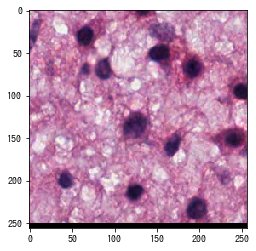

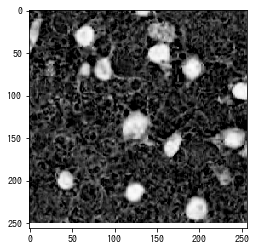

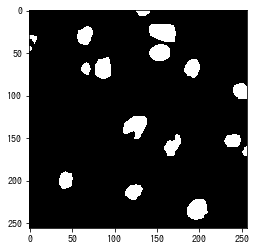

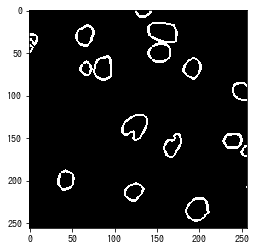

In [5]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomGaussionBlur(p=0.4,sigma=0.5,truncate=4,apply_dual=False),\
                                                RandomMedianBlur(p=0.4,disk_rad=1),\
                                                RandomHorizontalFlip(p=0.4),\
                                                RandomRotation( degrees=[60,120],p=0.38),\
                                                Scale(),\
                                                ToTensor()])

test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
if predict_hover:
    train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                          ,nuclei_mask_train_patch_dir, hor_train_patch_dir,ver_train_patch_dir\
                          ,transform=train_transform,attn_gray=True)
    train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
    test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                          ,nuclei_mask_test_patch_dir, hor_test_patch_dir,ver_test_patch_dir\
                          ,transform=test_transform,attn_gray=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)


else:
                                                
    train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                          ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                          ,transform=train_transform,attn_gray=True)
    train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
    test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                          ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                          ,transform=test_transform,attn_gray=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=False)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,0)


In [12]:
# model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.25,include_ffm=False)
# model=DualEncoding_U_Net_without_asm(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.4)
# model=DualEncodingDecoding_U_Net(img_ch1=3,img_ch2=1,output_ch1=1,output_ch2=1,dropout=0.45)
# model=AttnUNet(img_ch=3,output_ch=2,dropout=0.5)
model=U_Net(img_ch=3,output_ch=2,dropout=0.5)

# model=DualEncoding_U_Net_without_asm(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.4)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'Trained_models/model_CPM_17_unet_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model's state_dict:
Conv1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1.conv.0.bias 	 torch.Size([64])
Conv1.conv.1.weight 	 torch.Size([64])
Conv1.conv.1.bias 	 torch.Size([64])
Conv1.conv.1.running_mean 	 torch.Size([64])
Conv1.conv.1.running_var 	 torch.Size([64])
Conv1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1.conv.3.bias 	 torch.Size([64])
Conv1.conv.4.weight 	 torch.Size([64])
Conv1.conv.4.bias 	 torch.Size([64])
Conv1.conv.4.running_mean 	 torch.Size([64])
Conv1.conv.4.running_var 	 torch.Size([64])
Conv1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2.conv.0.bias 	 torch.Size([128])
Conv2.conv.1.weight 	 torch.Size([128])
Conv2.conv.1.bias 	 torch.Size([128])
Conv2.conv.1.running_mean 	 torch.Size([128])
Conv2.conv.1.running_var 	 torch.Size([128])
Conv2.conv.1.num_batches_tracked 	 torch.Size([])
Conv2.conv.3.weight 	 torch.Size([128, 128, 3, 3])
Conv2.conv.3.bias 	 t

In [7]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=False
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=80
predict_boundary=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()
# criterion=MultiClassBCE(weights=[0.11,0.89])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98))#,weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=2, min_lr=10e-06, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_CPM_17_v2_2020_02_07/model_optim.pth'
    load_model(filename,model,optimizer=None,scheduler=None)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                if predict_boundary:
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\
                    ,sample_batched['boundary_mask']
                    
                    h_e_train, h_train,nuclei_mask_train,boundary_mask_train = \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)\
                    ,boundary_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)
                
                else:
                    h_e_train, h_train,nuclei_mask_train= sample_batched['h_e']\
                    ,sample_batched['h']\
                    ,sample_batched['nuclei_mask']\

                    h_e_train, h_train,nuclei_mask_train= \
                    h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                    ,nuclei_mask_train.to(device, dtype = torch.float)
                    
                    gt_mask_train=nuclei_mask_train

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs,attn_maps_train = model(h_e_train)#,h_train)
                outputs=torch.sigmoid(outputs)
    
                if predict_boundary:
                    pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                else:
                    pred_nuclei_train=outputs
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%50==0:
                    
                    if predict_boundary:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
                                             pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                    else:
                        img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu()),dim=0)
                    
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
#                     for x,attn_map in enumerate(attn_maps_train):
#                         attn_maps_train[x]=attn_maps_train[x].detach().cpu()
#                         current_shape=list(attn_maps_train[x].shape)
#                         final_shape=list(attn_maps_train[0].shape)
                        
                        
#                         if x!=0:
#                             pad_shape=((final_shape[-2]-current_shape[-2])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
#                                       (final_shape[-1]-current_shape[-1])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
#                             attn_maps_train[x]=F.pad(attn_maps_train[x],pad_shape,"constant", 0)
                       
                        
                        
#                     img_tensor_attn=torch.cat(tuple(attn_maps_train),dim=0)
#                     img_grid_attn = torchvision.utils.make_grid(img_tensor_attn\
#                                                                 ,nrow=batch_size_test,padding=10)
#                     torchvision.utils.save_image\
#                     (img_grid_attn,os.path.join(BEST_MODEL_PATH,\
#                                             'attn_train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + epoch+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):
                
                
                if predict_boundary:
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']\
                    ,test_sample['boundary_mask']
                    
                    h_e_test, h_test,nuclei_mask_test,boundary_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)\
                    ,boundary_mask_test.to(device, dtype = torch.float)
                    
                    gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
                    
                else:
                
                    h_e_test, h_test,nuclei_mask_test= test_sample['h_e']\
                    ,test_sample['h']\
                    ,test_sample['nuclei_mask']

                    h_e_test, h_test,nuclei_mask_test = \
                    h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                    ,nuclei_mask_test.to(device, dtype = torch.float)

                    gt_mask_test=nuclei_mask_test
    
                test_outputs,attn_maps_test = model(h_e_test)#,h_test)
                test_outputs=torch.sigmoid(test_outputs)
        
        
                if predict_boundary:
                    pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
                else:
                    pred_nuclei_test=test_outputs
    
                test_loss = criterion(test_outputs, gt_mask_test)
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    if predict_boundary:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
                                                  pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    else:
                        img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu()),dim=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
#                     for x,attn_map in enumerate(attn_maps_test):
#                         attn_maps_test[x]=attn_maps_test[x].detach().cpu()
# #                         print(list(attn_maps[0].shape))
#                         current_shape=list(attn_maps_test[x].shape)
#                         final_shape=list(attn_maps_test[0].shape)
#                         if x!=0:
#                             pad_shape=((final_shape[-2]-current_shape[-2])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
#                                       (final_shape[-1]-current_shape[-1])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
#                             attn_maps_test[x]=F.pad(attn_maps_test[x],pad_shape,"constant", 0)
                            
                        
#                     img_tensor_attn_test=torch.cat(tuple(attn_maps_test),dim=0)
#                     img_grid_attn_test = torchvision.utils.make_grid(img_tensor_attn_test\
#                                                                 ,nrow=batch_size_test,padding=10)
#                     torchvision.utils.save_image\
#                     (img_grid_attn_test,os.path.join(BEST_MODEL_PATH,\
#                                             'attn_test_iter_{}.png'.format(epoch*len(train_loader)+j+1)))
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + epoch+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("{}/history.txt".format(BEST_MODEL_PATH), "wb") as fp:   #Pickling
    pickle.dump(history, fp)

Tesla V100-SXM2-32GB
initialized network with normal initialization
Learning Rate : 0.001



test_loss: 0.23974892309689302
test_dice :0.5862873072805811
saved model with test dice score: 0.5862873072805811
Learning Rate : 0.001



test_loss: 0.20966504990559687
test_dice :0.6856660217838051
saved model with test dice score: 0.6856660217838051
Learning Rate : 0.001



test_loss: 0.23422097759808033
test_dice :0.613248408794578
Learning Rate : 0.001



test_loss: 0.20707228465554745
test_dice :0.6884222462183986
saved model with test dice score: 0.6884222462183986
Learning Rate : 0.001



test_loss: 0.20210962249703623
test_dice :0.6506603760786996
Learning Rate : 0.001



test_loss: 0.1843407108921449
test_dice :0.7382912861564476
saved model with test dice score: 0.7382912861564476
Learning Rate : 0.001



test_loss: 0.24656937383802954
test_dice :0.6771841532932724
Learning Rate : 0.001



test_loss: 0.18050491376069738
test_dice :0.7362906880924064
Learning Rate : 0.001



test_loss: 0.18042245307407992
test_dice :0.7233614938414024
Learning Rate : 0.001



test_loss: 0.1678717412258261
test_dice :0.7545769371698632
saved model with test dice score: 0.7545769371698632
Learning Rate : 0.001


KeyboardInterrupt: 

In [ ]:
# file_name='model_CPM_17_2020_02_14/model_optim.pth'
# load_model(file_name,model,optimizer=None,scheduler=None)
# model=model.to("cuda:0" if torch.cuda.is_available() else "cpu")
# devide=("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# for i,sample_batched in enumerate(test_loader):
#     if i==0:
#         h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = sample_batched['h_e']\
#                             ,sample_batched['h']\
#                             ,sample_batched['nuclei_mask']\
#                             ,sample_batched['hor_map']\
#                             ,sample_batched['ver_map']
#         h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = \
#                     h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
#                     ,nuclei_mask_train.to(device, dtype = torch.float)\
#                     ,hor_map_train.to(device, dtype = torch.float),ver_map_train.to(device, dtype = torch.float)
                    
#         break

In [ ]:
# outputs,attn_maps_train= model(h_e_train,h_train)
# print(outputs.size())

In [ ]:
# nuclei,hor,ver=torch.chunk(outputs,3,dim=1)
# nuclei_np=nuclei[0].detach().cpu()
# nuclei_np=nuclei_np.numpy().transpose((2,1,0))
# nuclei_np=np.squeeze(nuclei_np)
# print(nuclei_np.shape)
# plt.imshow(nuclei_np,cmap='gray');plt.show()
# hor_np=hor[0].detach().cpu()
# hor_np=hor_np.numpy().transpose((2,1,0))
# hor_np=np.squeeze(hor_np)
# print(hor_np.shape)
# plt.imshow(hor_np,cmap='gray');plt.show()

In [ ]:
# save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler) 

In [ ]:
# os.system("rm -rf {}".format(BEST_MODEL_PATH))

In [ ]:
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(torch.cuda.current_device()))
# optimizer_selected='adam'
# scheduler_type='reduce_on_plateau'
# batchsize=batch_size_train
# no_steps=train_dataset.__len__()//batchsize
# restart_epochs=8
# num_epochs=100
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #criterion = SoftDiceLoss()#
# # criterion=HV_Loss()
# # criterion=MultiClassBCE(weights=[0.11,0.89])
# criterion=nn.BCELoss()
# # criterion=DE_loss()

# history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
# model = model.to(device)

# if optimizer_selected=='adam':
#     optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98),weight_decay=0.02)
# else:
#     optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


# if scheduler_type=='reduce_on_plateau':
#     scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6,\
#                                                verbose=True, threshold=0.0001, threshold_mode='rel',\
#                                                cooldown=2, min_lr=10e-06, eps=1e-08)
    
# else:
#     scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
#                                                      eta_min=1e-012, last_epoch=-1)

# if pretrained:
#     filename='model_CPM_17_v2_2020_02_07/model_optim.pth'
#     load_model(filename,model,optimizer=None,scheduler=None)
# else:
#     init_weights(model)

# best_val=0
# for epoch in range(num_epochs):
    
#     print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
#     # loop over the dataset multiple times
    
#     run_avg_train_loss=0
#     run_avg_train_dice=0
    
   
    
#     run_avg_test_loss=0
#     run_avg_test_dice=0
    
#     for mode in ['train','eval']:
     
#         if mode == 'train':
            
#             model.train()
#             loop=tqdm(train_loader)
            
#             for i, sample_batched in (enumerate(loop)):
#                 loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
#                 #Clear Gradients
#                 optimizer.zero_grad()
                
#                 # get the inputs; data is a list of [dapi, nuclei, boundary]
#                 if predict_hover:
#                     h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = sample_batched['h_e']\
#                     ,sample_batched['h']\
#                     ,sample_batched['nuclei_mask']\
#                     ,sample_batched['hor_map']\
#                     ,sample_batched['ver_map']
                    
#                     h_e_train, h_train,nuclei_mask_train,hor_map_train,ver_map_train = \
#                     h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
#                     ,nuclei_mask_train.to(device, dtype = torch.float)\
#                     ,hor_map_train.to(device, dtype = torch.float),ver_map_train.to(device, dtype = torch.float)
                    
#                     gt_mask_train=torch.cat((nuclei_mask_train,hor_map_train,ver_map_train),dim=1)
                    
                    
                
#                 else:
#                     h_e_train,h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
#                     ,sample_batched['h']\
#                     ,sample_batched['nuclei_mask']\
#                     ,sample_batched['boundary_mask']
                    
#                     h_e_train,h_train,nuclei_mask_train,boundary_mask_train = \
#                     h_e_train.to(device, dtype = torch.float)\
#                     ,h_train.to(device, dtype = torch.float)\
#                     ,nuclei_mask_train.to(device, dtype = torch.float)\
#                     ,boundary_mask_train.to(device, dtype = torch.float)
                    
#                     gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)

#                 # forward + backward + optimize
# #                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
#                 outputs,attn_maps_train= model(h_e_train,h_train)
                
                
    
#                 if predict_hover:
#                     pred_nuclei_train,pred_hor_train,pred_ver_train=torch.chunk(outputs,3,dim=1)
#                     pred_nuclei_train=torch.sigmoid(pred_nuclei_train)
#                     pred_hor_train=torch.nn.Identity()(pred_hor_train)
#                     pred_ver_train=torch.nn.Identity()(pred_ver_train)
#                     outputs=torch.cat((pred_nuclei_train,pred_hor_train,pred_ver_train),dim=1)
#                 else:
#                     outputs=torch.sigmoid(outputs)
#                     pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                    
                

                
#                 loss = criterion(outputs, gt_mask_train)
#                 dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
#                 run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
#                 run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
#                 if (i+1)%1==0:
                    
#                     if predict_hover:
#                         img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
#                                              pred_hor_train.detach().cpu(),hor_map_train.detach().cpu(),\
#                                              pred_ver_train.detach().cpu(),ver_map_train.detach().cpu()),dim=0)
#                     else:
#                         img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
#                                              pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                        
#                     img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
#                     torchvision.utils.save_image\
#                     (img_grid2,os.path.join(BEST_MODEL_PATH,\
#                                             'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
#                     plt.imshow(h_train[0][0].detach().cpu());plt.show()
                        
#                     for x,attn_map in enumerate(attn_maps_train):
#                         attn_maps_train[x]=attn_maps_train[x].detach().cpu()
#                         current_shape=list(attn_maps_train[x].shape)
#                         final_shape=list(attn_maps_train[0].shape)
                        
                        
#                         if x!=0:
#                             pad_shape=((final_shape[-2]-current_shape[-2])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
#                                       (final_shape[-1]-current_shape[-1])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
#                             attn_maps_train[x]=F.pad(attn_maps_train[x]*255,pad_shape,"constant", 0)
#                         plt.imshow(attn_maps_train[x][0][0]);plt.show()
                        
                        
#                     img_tensor_attn=torch.cat(tuple(attn_maps_train),dim=0)
#                     img_grid_attn = torchvision.utils.make_grid(img_tensor_attn\
#                                                                 ,nrow=batch_size_test,padding=10)
#                     torchvision.utils.save_image\
#                     (attn_maps_train[0][1],os.path.join(BEST_MODEL_PATH,\
#                                             'attn_train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
                    
                    
# #                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
#                     writer.add_scalar('Training dice score nuclei',
#                             run_avg_train_dice,
#                             epoch * len(train_loader) + i+1)
                
#                     writer.add_scalar('Training Loss',
#                             run_avg_train_loss,
#                             epoch * len(train_loader) + i+1)
                    
#                 loss.backward()
#                 optimizer.step()
                
#                 if scheduler_type!='reduce_on_plateau':
#                     scheduler.step()
                
                
#                 loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
#             history['train_loss'].append(run_avg_train_loss)
#             history['train_dice'].append(run_avg_train_dice)
            
#             writer.add_scalar('Train dice { epoch }',
#                             run_avg_train_dice,
#                             epoch+1)
                
#             writer.add_scalar('Train loss { epoch }',
#                     run_avg_train_loss,
#                     epoch * len(train_loader) + i+1)
                
                 
                    
#         elif mode =='eval':
#             #Clear Gradients
#             optimizer.zero_grad()
#             samples_test=len(test_loader)
#             model.eval()
#             val_loss=0
#             test_agg=0
#             for j, test_sample in enumerate(test_loader):
                
                
#                 if predict_hover:
#                     h_e_test, h_test,nuclei_mask_test,hor_map_test,ver_map_test = test_sample['h_e']\
#                     ,test_sample['h']\
#                     ,test_sample['nuclei_mask']\
#                     ,test_sample['hor_map']\
#                     ,test_sample['ver_map']
                    
#                     h_e_test, h_test,nuclei_mask_test,hor_map_test,ver_map_test = \
#                     h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
#                     ,nuclei_mask_test.to(device, dtype = torch.float)\
#                     ,hor_map_test.to(device, dtype = torch.float)\
#                     ,ver_map_test.to(device, dtype = torch.float)
                    
#                     gt_mask_test=torch.cat((nuclei_mask_test,hor_map_test,ver_map_test),dim=1)
                    
#                 else:
                
#                     h_e_test,h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
#                     ,test_sample['h']\
#                     ,test_sample['nuclei_mask']\
#                     ,test_sample['boundary_mask']
                    
#                     h_e_test,h_test,nuclei_mask_test,boundary_mask_test = \
#                     h_e_test.to(device, dtype = torch.float)\
#                     ,h_test.to(device, dtype = torch.float)\
#                     ,nuclei_mask_test.to(device, dtype = torch.float)\
#                     ,boundary_mask_test.to(device, dtype = torch.float)
                    
#                     gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
    
#                 test_outputs,attn_maps_test = model(h_e_test,h_test)
                
        
        
#                 if predict_hover:
#                     pred_nuclei_test,pred_hor_test,pred_ver_test=torch.chunk(test_outputs,3,dim=1)
#                     pred_nuclei_test=torch.sigmoid(pred_nuclei_test)
#                     pred_hor_test=torch.nn.Identity()(pred_hor_test)
#                     pred_ver_test=torch.nn.Identity()(pred_ver_test)
#                     test_outputs=torch.cat((pred_nuclei_test,pred_hor_test,pred_ver_test),dim=1)
#                 else:
#                     test_outputs=torch.sigmoid(test_outputs)
#                     pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
    
#                 test_loss = criterion(test_outputs, gt_mask_test)
#                 test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                
#                 run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
#                 run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
#                 if (j+1)%50==0:
#                     if predict_hover:
#                         img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
#                                                   pred_hor_test.detach().cpu(),hor_map_test.detach().cpu(),\
#                                                   pred_ver_test.detach().cpu(),ver_map_test.detach().cpu()),dim=0)
#                     else:
#                         img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
#                                                   pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    
                    
#                     img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
#                     torchvision.utils.save_image\
#                     (img_grid,os.path.join(BEST_MODEL_PATH,\
#                                             'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
#                     for x,attn_map in enumerate(attn_maps_test):
#                         attn_maps_test[x]=attn_maps_test[x].detach().cpu()
# #                         print(list(attn_maps[0].shape))
#                         current_shape=list(attn_maps_test[x].shape)
#                         final_shape=list(attn_maps_test[-1].shape)
#                         if x!=len(attn_maps_test):
#                             pad_shape=((final_shape[-2]-current_shape[-2])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-2]-current_shape[-2])//2,\
#                                       (final_shape[-1]-current_shape[-1])//2,\
#                                        final_shape[-2]-current_shape[-2]-(final_shape[-1]-current_shape[-1])//2)
#                             attn_maps_test[x]=F.pad(attn_maps_test[x],pad_shape,"constant", 0)
                            
                        
#                     img_tensor_attn_test=torch.cat(tuple(attn_maps_test),dim=0)
#                     img_grid_attn_test = torchvision.utils.make_grid(img_tensor_attn_test\
#                                                                 ,nrow=batch_size_test,padding=10)
#                     torchvision.utils.save_image\
#                     (img_grid_attn_test,os.path.join(BEST_MODEL_PATH,\
#                                             'attn_test_iter_{}.png'.format(epoch*len(train_loader)+j+1)))
                    
# #                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
#                     writer.add_scalar('Testing dice score ',\
#                                       run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
#                     writer.add_scalar('Testing Loss',\
#                                       run_avg_test_loss,epoch * len(test_loader) + j+1)
                
#             print("test_loss: {}\ntest_dice :{}"\
#                   .format(run_avg_test_loss,run_avg_test_dice))
#             history['test_loss'].append(run_avg_test_loss)
#             history['test_dice'].append(run_avg_test_dice)
            
#             writer.add_scalar('Test dice { epoch }',
#                             run_avg_test_dice,
#                             epoch+1)
                
#             writer.add_scalar('Test loss { epoch }',
#                     run_avg_test_loss,
#                     epoch * len(train_loader) + i+1)
            
#             if run_avg_test_dice>best_val:
#                 best_val=run_avg_test_dice
#                 save_model(model,optimizer,BEST_MODEL_PATH+\
#                            '/model_optim.pth',scheduler=scheduler)
#                 print("saved model with test dice score: {}".format(best_val))
#             if scheduler_type=='reduce_on_plateau':
#                 scheduler.step(run_avg_test_loss)
    
# #             print("val_loss {}".format(val_loss/samples_test))
# save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

# with open("{}/history.txt".format(BEST_MODEL_PATH), "wb") as fp:   #Pickling
#     pickle.dump(history, fp)
    
    
    